<strong>Loading Datasets</strong><br>
Clinical trial data

In [0]:
dbutils.fs.ls("/FileStore/tables/")

[FileInfo(path='dbfs:/FileStore/tables/FaultDataset.csv', name='FaultDataset.csv', size=1703184, modificationTime=1681127689000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.csv', name='clinicaltrial_2019.csv', size=42400056, modificationTime=1681830827000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.zip', name='clinicaltrial_2019.zip', size=9707871, modificationTime=1680912459000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=46318151, modificationTime=1681833990000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.zip', name='clinicaltrial_2020.zip', size=10599182, modificationTime=1680912463000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1682483041000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.zip', name='clinicaltrial_2021.zip', size=11508457, modificationTime=1680912508000),
 FileInfo(pat

In [0]:
#Variable fileroot for Clinicaltrial dataset
fileroot = "clinicaltrial_2021"
#copies fileroot from Filestore to tmp folder 
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")

#set environment variable to fileroot
import os
os.environ['fileroot'] = fileroot

In [0]:
%sh
#unzips fileroot to tmp folder
unzip -d /tmp /tmp/$fileroot.zip

Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  


In [0]:
# Move the fileroot file from the temporary directory to the FileStore directory
dbutils.fs.mv("file:/tmp/" + fileroot + ".csv", "/FileStore/tables/", True)

#List Files that match fileroot in Filestore directory
dbutils.fs.ls("/FileStore/tables/" + fileroot + ".csv" )

[FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1682614465000)]

In [0]:
#Creation of rdd ClinicaltrialRDD using sparkcontext textfile function
ClinicaltrialRDD = sc.textFile("/FileStore/tables/" + fileroot + ".csv")

Processing Data - Defining Functions

In [0]:
#Delimeter Split Function
def split_by_delimiter(rdd, delimiter):
    # Split the RDD by the specified delimiter
    myRDD = rdd.map(lambda x: x.split(delimiter))
    
    # Return the resulting RDD
    return myRDD
#Remove Header Function
def remove_header(rdd):
    header = rdd.first()
    # Filter the RDD to remove header rows
    remove_header = rdd.filter(lambda x: x != header)
    
    # Return the resulting RDD
    return remove_header
#Remove null values Function
def remove_null(rdd, col_index):
    # Use filter to remove any empty strings from the specified column of each element of the RDD
    strip_null = rdd.filter(lambda x: x[col_index].strip())

    # Return the resulting RDD
    return strip_null

<h3>Question One</h3>
Number of Studies

In [0]:
 #Get the distinct count of number of studies

Num_Clinicaltrials = remove_header(ClinicaltrialRDD)
Num_Clinicaltrials = Num_Clinicaltrials.distinct().count()


print("Number of clinical studies:", Num_Clinicaltrials)

Number of clinical studies: 387261


In [0]:
#Splits ClinitrialRDD by "|"
ClinicaltrialRDD = split_by_delimiter(ClinicaltrialRDD, "|")
#Removes header row from ClinicaltrialRDD
ClinicaltrialRDD = remove_header(ClinicaltrialRDD)

<h3>Question Two</h3>
Types of Studies in the
dataset along with the frequencies of each type ordered from most frequent to least frequent

In [0]:
#Maps and count the sixth row of ClinicaltrialRDD then reduce to key-value pairs
typeCounts = ClinicaltrialRDD.map(lambda x: (x[5], 1)).reduceByKey(lambda x, y: x + y)
#Sorts counts column descending order
typeCounts = typeCounts.sortBy(lambda x: x[1], ascending=False)
#use collect to display results
typeCounts.collect()

[('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

<h3>Question Three</h3>
 Top 5 conditions with their frequencies.

In [0]:
#Maps and counts the eigth row of ClinicaltrialRDD then reduces to key-value pairs
ConditionsRDD = ClinicaltrialRDD.map(lambda x: (x[7], 1)).reduceByKey(lambda x, y: x + y)
#use collect to display results
ConditionsRDD.collect()

[('', 65131),
 ('Tuberculosis,Lung Diseases,Pulmonary Disease', 3),
 ('Asthma', 2427),
 ('Lymphoma', 2838),
 ('Myositis', 32),
 ('Appendicitis,Stomach Ulcer,Cholecystolithiasis,Cholelithiasis,Gallstones',
  1),
 ('Hookworm Infections,Celiac Disease', 1),
 ('Ascites', 56),
 ('Sleep Apnea Syndromes,Sleep Apnea', 173),
 ('Iatrogenic Disease', 8),
 ('Cystic Fibrosis,Fibrosis', 767),
 ('Depressive Disorder,Depression', 528),
 ('Myocardial Infarction,Cardiomyopathies,Microvascular Angina,Takotsubo Cardiomyopathy,Syndrome,Infarction',
  1),
 ('Hyperphagia', 14),
 ('Acute Coronary Syndrome,Syndrome', 318),
 ('Molluscum Contagiosum,Keratosis,Bowens Disease,Rosacea,Skin Diseases', 1),
 ('Necrosis,Neovascularization,Fat Necrosis', 1),
 ('Breast Neoplasms', 6054),
 ('Depression,Depressive Disorder', 1485),
 ('Infections,Bacterial Infections,Gram-Positive Bacterial Infections', 2),
 ('Malaria', 971),
 ('Atrial Fibrillation', 1615),
 ('Shock', 458),
 ('Neuralgia', 337),
 ('Tooth Loss', 63),
 ('Gliob

In [0]:
#use remove null function to remove null cells from data
ConditionsRDD = remove_null(ConditionsRDD, 0)
#Iterates through keys splits by comma and then maps to key-value pairs
ConditionsRDD = ConditionsRDD.flatMap(lambda x: [(key, x[1]) for key in x[0].split(',')]) \
                             .reduceByKey(lambda x, y: x + y)
#Sorts Values in Descending order
ConditionsRDD_Top5 = ConditionsRDD.sortBy(lambda x: x[1], ascending=False)
#use take to show results
ConditionsRDD_Top5.take(5)

[('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

<strong>Loading Dataset</strong><br>
Pharma Data

In [0]:
#Variable fileroot for pharma dataset
fileroot = "pharma"
dbutils.fs.cp("/FileStore/tables/" + fileroot + ".zip", "file:/tmp/")

#set environment variable to fileroot
import os
os.environ['fileroot'] = fileroot

In [0]:
%sh
#unzip fileroot to tmp folder
unzip -d /tmp /tmp/$fileroot.zip

Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
# Move the fileroot file from the temporary directory to the FileStore directory
dbutils.fs.mv("file:/tmp/" + fileroot + ".csv", "/FileStore/tables/", True)

#List Files that match fileroot in Filestore directory
dbutils.fs.ls("/FileStore/tables/" + fileroot + ".csv")

[FileInfo(path='dbfs:/FileStore/tables/pharma.csv', name='pharma.csv', size=678999, modificationTime=1682614491000)]

In [0]:
#Creation of rdd PharmaRDD using sparkcontext textfile function
PharmaRDD = sc.textFile("/FileStore/tables/" + fileroot + ".csv")

<h3>Question Four</h3>
10 most common sponsors that are not pharmaceutical companies, along
with the number of clinical trials they have sponsored.

In [0]:
#Split PharmaRDD by ""," and ","   
PharmaRDD = PharmaRDD.map(lambda x: x.split('",')[1].split('"')[1])
#Remove header from PharmaRDD
PharmaRDD = remove_header(PharmaRDD)
#Display results
PharmaRDD.collect()

['Abbott Laboratories',
 'AbbVie',
 'AbbVie',
 'Abbott Laboratories',
 'Johnson & Johnson',
 'Abbott Laboratories',
 'Abbott Laboratories',
 'Johnson & Johnson',
 'Johnson & Johnson',
 'Abbott Laboratories',
 'AbbVie',
 'AbbVie',
 'Pfizer',
 'Pfizer',
 'Bristol-Myers Squibb',
 'Amgen',
 'Amgen',
 'Amgen',
 'Amneal Pharmaceuticals',
 'Astellas Pharma',
 'AstraZeneca',
 'AstraZeneca',
 'AstraZeneca',
 'AstraZeneca',
 'AstraZeneca',
 'AstraZeneca',
 'AstraZeneca',
 'Sanofi',
 'Sanofi',
 'AVEO Pharmaceuticals',
 'Biogen Idec',
 'Biogen Idec',
 'Bausch Health',
 'Bausch Health',
 'GlaxoSmithKline',
 'Boehringer Ingelheim',
 'Boehringer Ingelheim',
 'Eli Lilly',
 'Eli Lilly',
 'Bristol-Myers Squibb',
 'Bristol-Myers Squibb',
 'Bristol-Myers Squibb',
 'Bristol-Myers Squibb',
 'Bristol-Myers Squibb',
 'Bristol-Myers Squibb',
 'Bristol-Myers Squibb',
 'Alcami',
 'Alcami',
 'Teva Pharmaceutical Industries',
 'Teva Pharmaceutical Industries',
 'Teva Pharmaceutical Industries',
 'Merck',
 'Novarti

In [0]:
PharmaRDD = PharmaRDD.collect()
#Filter sponsors in CllinicalRDD that are not in PharmaRDD 
Sponsors = ClinicaltrialRDD.filter\
(lambda x: x[1] not in PharmaRDD)\
.map(lambda x: (x[1], 1))\
.reduceByKey(lambda x, y: x + y)


In [0]:
#order and display results
Sponsortopten = Sponsors.takeOrdered(10, key=lambda x: -x[1])
Sponsortopten

[('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

<h3>Question Five</h3>
Plot number of completed studies each month in a given year

In [0]:
# Filter for completed studies in 2021
completed_studies_2021 = ClinicaltrialRDD.filter(lambda x: x[2].strip('"') == 'Completed' and x[4].strip('"').endswith("2021"))

# Extract the month from the completion date
completed_studies_2021 = completed_studies_2021.map(lambda x: x[4].strip('"').split(' ')[0])

# Count the number of completed studies per month
completed_studies_2021 = completed_studies_2021.map(lambda month: (month, 1)).reduceByKey(lambda x, y: x + y)

# Collect the results as a list of tuples
completed_studies_2021.collect()


[('May', 984),
 ('Jan', 1131),
 ('Jun', 1094),
 ('Mar', 1227),
 ('Feb', 934),
 ('Aug', 700),
 ('Apr', 967),
 ('Jul', 819),
 ('Oct', 187),
 ('Sep', 528)]

In [0]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sorted_months = completed_studies_2021.sortBy(lambda x: months.index(x[0]))

# Collect the sorted RDD as a list
sorted_months.collect()

[('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

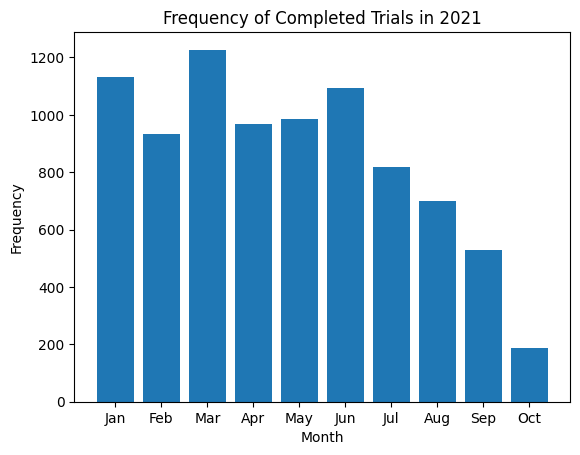

In [0]:
import matplotlib.pyplot as plt

# Get the sorted RRD as a list of tuples
data = sorted_months.collect()

# Extract the month names and the counts into separate lists
Months = [x[0] for x in data]
Frequency = [x[1] for x in data]

# Create a bar chart
plt.bar(Months, Frequency)

# Set the title and axis labels
plt.title("Frequency of Completed Trials in 2021")
plt.xlabel("Month")
plt.ylabel("Frequency")

# Show the chart 
plt.show()

<h3>Additional Analysis</h3>
<bold> Distribution of Clinical Interventions</bold>

In [0]:
#Maps and count the seventh row of ClinicaltrialRDD then reduce to key-value pairs
InterventionCounts = ClinicaltrialRDD.map(lambda x: (x[8], 1)).reduceByKey(lambda x, y: x + y)
#Sorts counts column descending order
InterventionCounts = InterventionCounts.sortBy(lambda x: x[1], ascending=False)
#use collect to display results
InterventionCounts.collect()

[('', 253837),
 ('Vaccines', 1771),
 ('Anesthetics', 779),
 ('Insulin', 738),
 ('Pembrolizumab', 708),
 ('Metformin', 689),
 ('Lidocaine', 660),
 ('Antibodies', 616),
 ('Bupivacaine', 605),
 ('Nicotine', 559),
 ('Botulinum Toxins,abobotulinumtoxinA', 505),
 ('Rituximab', 473),
 ('Bevacizumab', 472),
 ('Dexmedetomidine', 426),
 ('Nivolumab', 426),
 ('Ropivacaine', 423),
 ('Sirolimus', 413),
 ('Oxytocin', 401),
 ('Dexamethasone', 399),
 ('Ketamine', 394),
 ('Paclitaxel', 391),
 ('Vitamin D,Cholecalciferol', 387),
 ('Gemcitabine', 385),
 ('Epoetin Alfa', 371),
 ('Tranexamic Acid', 369),
 ('Docetaxel', 364),
 ('Ranibizumab', 362),
 ('Aspirin', 344),
 ('Atorvastatin', 343),
 ('Everolimus', 330),
 ('Sorafenib', 330),
 ('Hyaluronic Acid', 324),
 ('Tacrolimus', 294),
 ('Acetaminophen', 291),
 ('Temozolomide', 291),
 ('Pregabalin', 290),
 ('Vitamin D', 283),
 ('Acetylcysteine,N-monoacetylcystine', 282),
 ('Adalimumab', 277),
 ('Nivolumab,Ipilimumab', 269),
 ('Capecitabine', 265),
 ('Aflibercept

In [0]:
#use remove null function to remove null cells from data
InterventionCounts = remove_null(InterventionCounts, 0)
#Iterates through keys splits by comma and then maps to key-value pairs
InterventionCounts = InterventionCounts.flatMap(lambda x: [(key, x[1]) for key in x[0].split(',')]) \
                             .reduceByKey(lambda x, y: x + y)
#Sorts Values in Descending order
InterventionCounts = InterventionCounts.sortBy(lambda x: x[1], ascending=False)
#use take to show results
InterventionCounts.take(10)

[('Paclitaxel', 3225),
 ('Cyclophosphamide', 3012),
 ('Dexamethasone', 2516),
 ('Carboplatin', 2392),
 ('Antibodies', 2335),
 ('Vaccines', 2214),
 ('Gemcitabine', 2195),
 ('Bevacizumab', 2005),
 ('Docetaxel', 1953),
 ('Rituximab', 1740)]